# Adding theoretical layers to the simulation and calculating reflectivity
**(MD2reflect version 0.12)**

In [ ]:
# Run this cell if this notebook is in a subfolder of the module
import sys
sys.path.append("../../")

In [1]:
from md2reflect import *

## Calculate the simulation scattering length density without the substrate contribution

It is important that we calculate the scattering length density of the simulation **without the substrate contribution** because we will be adding the substrate here with a theoretical layer. This first part is covered elsewhere in other examples, so no details will be given.

In [2]:
traj=load_trajectory("../../simulations/traj3_3frames.pdb")

<mdtraj.Trajectory with 3 frames, 29764 atoms, 3028 residues, and unitcells>
[0 1 2]
Loading time: 0:00:01.370668 (hh:mm:ss)


In [3]:
zbin_interval, box_zlength, zbins_number, zbin_volume = select_zbinning(traj, zbin_interval=0.5)

Length of simulation box in x direction:  49.85000133514404 Å
Length of simulation box in y direction:  49.85000133514404 Å
Length of simulation box in z direction:  160.0 Å 

Thickness of z slices:  0.5 Å
Number of z bins:  320
Volume of z bins:  1242.51127243042 Å^3


In [4]:
number_atoms_elements_allframes = count_number_atoms(traj, zbins_number)
number_density_elements_allframes = calculate_number_density_elements(number_atoms_elements_allframes, zbin_volume)

0:00:00.448228 (hh:mm:ss.ss) for one frame. 
There are 2 frames left. 
Estimated running time: 0:00:01.344684 (hh:mm:ss.ss)

Actual running time: 0:00:01.391859 (hh:mm:ss.ss)



In [5]:
bc_table_neutrons = obtain_elements_bc_neutrons(traj)

In [6]:
SLD_elements = calculate_SLD_elements(number_density_elements_allframes, bc_table_neutrons)

substrate_element = "copper"
SLD_total, SLD_total_no_substrate = calculate_SLD_total(SLD_elements, substrate_element)

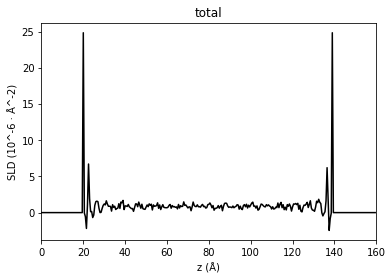

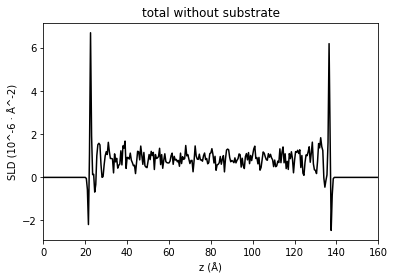

In [7]:
save_SLD_total(SLD_total, SLD_total_no_substrate, zbin_interval, filename="SLD_total_elements_neutrons")

## Build substrate layers

 **1. Set up the initial semi-infinite substrate layer:**

In [8]:
substrate_element = "silicon"
substrate_layers = build_substrate_layer(substrate_element)
substrate_layers

 Substrate:
Density = 2.33 g/cm^3
Mass = 28.0855 g/mol

Number density = 0.04996026551316515 Å^-3
bc = ( 4.15071 +i 0.0 ) fm
SLD substrate = ( 2.0737057366814975e-06 +i 0.0 ) Å^-2


[(2.0737057366814975e-06, 0.0, 0.0, 0.0)]

**2. Add more layers between the semi-infinite substrate and the simulation scattering length density. In this case, a 10 Å silicon dioxide layer:**

In [9]:
substrate_layers += [(3.85e-06, 0.0, 10, 0.)]
substrate_layers

[(2.0737057366814975e-06, 0.0, 0.0, 0.0), (3.85e-06, 0.0, 10, 0.0)]

(SLD (Å^-2), SLD_abs (Å^-2), thickness (Å), roughness(Å))

## Build environment layers

**1. Select an appropriate range to average the SLD and estimate the environment or bulk SLD value.**

To determine the environment SLD, we will average the central SLD values of the simulation where we expect them to more closely resemble the bulk. We can use the **show_SLD_range()** function to find a good range or check that it is:

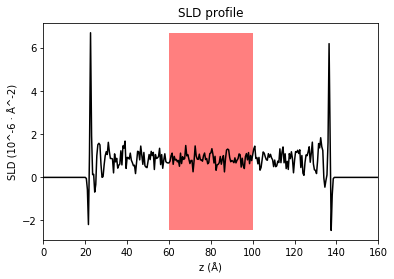

Start: position =  60 Å , index = 120
End: position =  100 Å , index = 200

Interval: position =  40 Å , index = 81


(120, 200, 81)

In [10]:
show_SLD_range(SLD_total_no_substrate[0], zbin_interval, starting_point=60, ending_point=100, 
               distance_input=True, show=True)

**2. Set up the initial semi-infinite environment layer.**  

In [11]:
environment_layers = build_average_environmental_layer(SLD_total_no_substrate, 
                                                       60, 100, distance_input=True, 
                                                       zbin_interval=zbin_interval)
environment_layers

SLD environment = ( 8.569835631488211e-07 +i 0.0 ) Å^-2


[(8.569835631488211e-07, 0.0, 0.0, 0.0)]

(SLD (Å^-2), SLD_abs (Å^-2), thickness (Å), roughness(Å))

**3. Like with the substrate layers, it is also possible to construct multiple layers on this other side of the simulation. But, in this case, it will not be necessary.**

## Select an appropriate range of the scattering length density

We will select the left side of the simulation (from the substrate to the "bulk" in the midle):

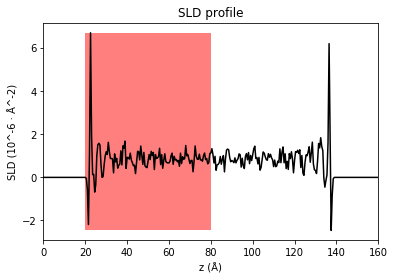

Start: position =  20 Å , index = 40
End: position =  80 Å , index = 160

Interval: position =  60 Å , index = 121


(40, 160, 121)

In [12]:
show_SLD_range(SLD_total_no_substrate[0], zbin_interval, starting_point=20, ending_point=80, 
               distance_input=True, show=True)

The **show_SLD_range()** function outputs the index of the z bins (40, 160) corresponding to the interval positions on the z axis that were introduced (20 Å, 80 Å). Or it outputs the positions of the interval if what was introduced were the indexes.

Knowing the index, we can now check the SLD values close to this and obtain a better adjustment of the range. We realise that the value at the index 40 is 0.0 (still in the region without any contribution), so we can adjust this to 41 instead to make sure we don't take spurious points:

In [13]:
print(SLD_total_no_substrate[0][40:50])

[0.0, -5.017928989197545e-08, -5.620080467901252e-07, -2.1878674747815867e-06, 1.089486024556366e-06, 6.71129363976611e-06, 1.9258373905824425e-06, 1.2735954206445585e-07, 1.4246389866044837e-07, -6.828694586732773e-07]


## Combine simulation scattering length density range with theoretical layers + plot + save

In [14]:
SLD_tuned_left = build_SLD_left(SLD_total_no_substrate, 41, 160, 
                                substrate_layers, environment_layers)

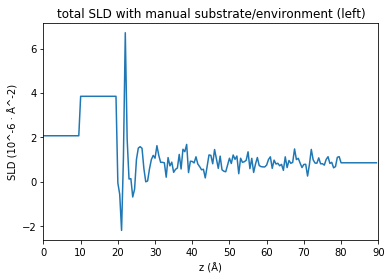

In [15]:
save_SLD_left(SLD_tuned_left, substrate_layers, environment_layers, zbin_interval, 
              filename="SLD_tuned_left_elements", show=True)

## Calculate the reflectivity of the constructed scattering length density + plot + save

The argument "incoming_beam" is to specify from which side the x-rays or the neutron beam are impacting the surface. in this case it is neutron reflectivity due to the scattering lengths we took to calculate the scattering length density contributions.

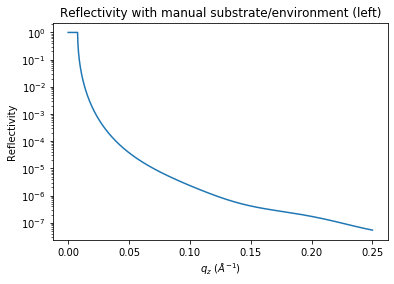

In [16]:
reflectivity_MD_left = calculate_reflectivity(SLD_tuned_left, zbin_interval, incoming_beam="right")
save_reflectivity_left(reflectivity_MD_left, filename="R_tuned_left_elements", show=True)